In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

# 读取数据
click_history = pd.read_csv('click_history.csv')
news = pd.read_csv('news.csv')
user_predict = pd.read_csv('user_predict.csv')

d:\Anaconda\envs\cxl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# 合并两个表格
merged_df = click_history.merge(news, on='news_id', how='left')
merged_df = merged_df[['user_id', 'news_id', 'cateory']]

# 添加label列
merged_df['label'] = 1

# 将'news_id', 'category'对应到nc中
new_category = merged_df[['news_id', 'cateory']]
new_category.drop_duplicates(subset=['news_id'])
nc = new_category.values.tolist()

In [4]:
# 隐式反馈模型
class ImplicitFeedbackModel(nn.Module):
    def __init__(self, num_users, num_news, num_categories, embedding_dim):
        super(ImplicitFeedbackModel, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.news_embed = nn.Embedding(num_news, embedding_dim)
        self.category_embed = nn.Embedding(num_categories, embedding_dim)
        self.fc1 = nn.Linear(3 * embedding_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, user_ids, news_ids, category_ids):
        user_emb = self.user_embed(user_ids)
        news_emb = self.news_embed(news_ids)
        category_emb = self.category_embed(category_ids)
        x = torch.cat([user_emb, news_emb, category_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
import torch
import torch.nn as nn

class AnotherImplicitFeedbackModel(nn.Module):
    def __init__(self, num_users, num_news, num_categories, embedding_dim):
        super(AnotherImplicitFeedbackModel, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.news_embed = nn.Embedding(num_news, embedding_dim)
        self.category_embed = nn.Embedding(num_categories, embedding_dim)
        self.fc1 = nn.Linear(3 * embedding_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, user_ids, news_ids, category_ids):
        user_emb = self.user_embed(user_ids)
        news_emb = self.news_embed(news_ids)
        category_emb = self.category_embed(category_ids)
        x = torch.cat([user_emb, news_emb, category_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
batch_size = 4  # 每批处理的行数

# 计算需要多少批次
num_rows = len(merged_df)
num_batches = num_rows // batch_size + 1

# 模型超参数
num_users = merged_df['user_id'].nunique()
num_news = merged_df['news_id'].nunique()
num_categories = merged_df['cateory'].nunique()
embedding_dim = 32

In [7]:
train_losses, test_accuracies = [], []
train_losses1, test_accuracies1 = [], []

In [17]:
acc=[]

In [8]:
import tqdm

# 分批处理数据
for i in range(1, 24):
    print('当前正在训练批次：', i)
    start = i * batch_size
    end = (i + 1) * batch_size

    # 提取当前批次的数据
    batch_data = merged_df.iloc[start:end]

    users = batch_data['user_id'].unique()
    # new_category = news['news_id']
    all_combinations = pd.DataFrame([(user, n, c) for user in users for n, c in nc],
                                    columns=['user_id', 'news_id', 'cateory'])

    # 将所有组合的数据框与原始数据合并，并添加 "label" 列
    batch_data = pd.merge(all_combinations, batch_data, on=['user_id', 'news_id', 'cateory'], how='left')
    batch_data['label'] = batch_data['label'].apply(lambda x: 1 if x == 1 else 0)

    # 数据预处理：将用户ID、新闻ID、类别特征进行标签编码
    user_encoder = LabelEncoder()
    news_encoder = LabelEncoder()
    category_encoder = LabelEncoder()

    batch_data['user_id'] = user_encoder.fit_transform(batch_data['user_id'])
    batch_data['news_id'] = news_encoder.fit_transform(batch_data['news_id'])
    batch_data['cateory'] = category_encoder.fit_transform(batch_data['cateory'])

    # 划分训练集和测试集
    X = batch_data[['user_id', 'news_id', 'cateory']].values
    y = batch_data['label'].values  # 假设 'label' 是点击/不点击的标签

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # print(X_train.T.shape)
    # print(X_train.shape)
    try:
        # 加载模型
        model = ImplicitFeedbackModel(num_users, num_news, num_categories, embedding_dim).to(device)
        model.load_state_dict(torch.load('model_weights1.pth'))
    except:
        # 创建模型实例
        model = ImplicitFeedbackModel(num_users, num_news, num_categories, embedding_dim).to(device)

    # 损失函数和优化器
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 训练模型
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        inputs = torch.LongTensor(X_train).to(device)
        labels = torch.FloatTensor(y_train).to(device)
        labels = labels.view(-1, 1)
        outputs = model(*inputs.T)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # 模型评估
    model.eval()
    with torch.no_grad():
        inputs = torch.LongTensor(X_test).to(device)
        labels = torch.FloatTensor(y_test).to("cpu")
        outputs = model(*inputs.T)
        predictions = torch.sigmoid(outputs).cpu()
        # 计算AUC
        auc = roc_auc_score(labels, predictions)

        # 计算准确率
        threshold = 1  
        predicted_labels = (predictions > threshold).int()
        accuracy = accuracy_score(labels, predicted_labels)
        test_accuracies.append(accuracy)
        # 打印评估指标
        print(labels)
        # acc.append(labels==predicted_labels)
        print(f'AUC: {auc}')
        print(f'准确率: {accuracy}')

    # 保存模型
    torch.save(model.state_dict(), 'model_weights1.pth')

    # 在处理完当前批次后，可以释放内存
    del batch_data
    # break


当前正在训练批次： 13
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.9895583416529858
准确率: 0.997409279856196
当前正在训练批次： 14
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.9959386510136871
准确率: 0.9985664532075048
当前正在训练批次： 15
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.9673083375308985
准确率: 0.9946163352432311
当前正在训练批次： 16
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.892656144058607
准确率: 0.9973306370070778
当前正在训练批次： 17
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.7714703154892188
准确率: 0.9998921469497809
当前正在训练批次： 18
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.41512220573578235
准确率: 0.9994607347489046
当前正在训练批次： 19
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.9543684179257114
准确率: 0.9986046511627907
当前正在训练批次： 20
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.945109285895556
准确率: 0.9973328839456241
当前正在训练批次： 21
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.5014272350682996
准确率: 0.9981020830649486
当前正在训练批次： 22
tensor([0., 0., 0.,  ..., 0., 0., 0.])
AUC: 0.9812162362098144
准确率: 0.9972969329288844


In [9]:
import tqdm
batch_size = 4
# 分批处理数据
for i in range(25, 50):
    print('当前正在训练批次：', i)
    start = i * batch_size
    end = (i + 1) * batch_size

    # 提取当前批次的数据
    batch_data = merged_df.iloc[start:end]

    users = batch_data['user_id'].unique()
    # new_category = news['news_id']
    all_combinations = pd.DataFrame([(user, n, c) for user in users for n, c in nc],
                                    columns=['user_id', 'news_id', 'cateory'])

    # 将所有组合的数据框与原始数据合并，并添加 "label" 列
    batch_data = pd.merge(all_combinations, batch_data, on=['user_id', 'news_id', 'cateory'], how='left')
    batch_data['label'] = batch_data['label'].apply(lambda x: 1 if x == 1 else 0)

    # 数据预处理：将用户ID、新闻ID、类别特征进行标签编码
    user_encoder = LabelEncoder()
    news_encoder = LabelEncoder()
    category_encoder = LabelEncoder()

    batch_data['user_id'] = user_encoder.fit_transform(batch_data['user_id'])
    batch_data['news_id'] = news_encoder.fit_transform(batch_data['news_id'])
    batch_data['cateory'] = category_encoder.fit_transform(batch_data['cateory'])

    # 划分训练集和测试集
    X = batch_data[['user_id', 'news_id', 'cateory']].values
    y = batch_data['label'].values  # 假设 'label' 是点击/不点击的标签

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # print(X_train.T.shape)
    # print(X_train.shape)
    try:
        # 加载模型
        model1 = AnotherImplicitFeedbackModel(num_users, num_news, num_categories, embedding_dim).to(device)
        model1.load_state_dict(torch.load('model_weights2.pth'))
    except:
        # 创建模型实例
        model1 = AnotherImplicitFeedbackModel(num_users, num_news, num_categories, embedding_dim).to(device)

    # 损失函数和优化器
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model1.parameters(), lr=0.001)
    # 训练模型
    num_epochs = 10
    for epoch in range(num_epochs):
        model1.train()
        optimizer.zero_grad()
        inputs = torch.LongTensor(X_train).to(device)
        labels = torch.FloatTensor(y_train).to(device)
        labels = labels.view(-1, 1)
        outputs = model1(*inputs.T)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses1.append(loss.item())
    # 模型评估
    model1.eval()
    with torch.no_grad():
        inputs = torch.LongTensor(X_test).to(device)
        labels = torch.FloatTensor(y_test).to(device)
        outputs = model1(*inputs.T)
        predictions = torch.sigmoid(outputs).cpu()
    # 计算AUC
    auc = roc_auc_score(y_test, predictions)
    # 计算准确率
    threshold = 1  # 设置一个阈值，通常是0.5
    predicted_labels = (predictions > threshold).int()
    accuracy = accuracy_score(y_test, predicted_labels)
    # print("真实值:",y_test)
    # print("预测值:",predictions)
    # print(set(predicted_labels))
    test_accuracies1.append(accuracy)
    # 打印评估指标
    print(f'AUC: {auc}')
    print(f'准确率: {accuracy}')

    # 保存模型
    torch.save(model1.state_dict(), 'model_weights2.pth')

    # 在处理完当前批次后，可以释放内存
    del batch_data
    # break


当前正在训练批次： 25
AUC: 0.9216359849692841
准确率: 0.9978833838894506
当前正在训练批次： 26
AUC: 0.7718312806676116
准确率: 0.9982855858892259
当前正在训练批次： 27
AUC: 0.9189989290426793
准确率: 0.9931782945736434
当前正在训练批次： 28
AUC: 0.7827566063220036
准确率: 0.998939445006179
当前正在训练批次： 29
AUC: 0.9428072876427114
准确率: 0.996312019341676
当前正在训练批次： 30
AUC: 0.9503576229086315
准确率: 0.9974939107874183
当前正在训练批次： 31
AUC: 0.9494896509831555
准确率: 0.9988495674643298
当前正在训练批次： 32
AUC: 0.565269097241728
准确率: 0.9999438265363443
当前正在训练批次： 33
AUC: 0.8875952463652086
准确率: 0.9944635434220874
当前正在训练批次： 34
AUC: 0.907619406660929
准确率: 0.9970744860128076


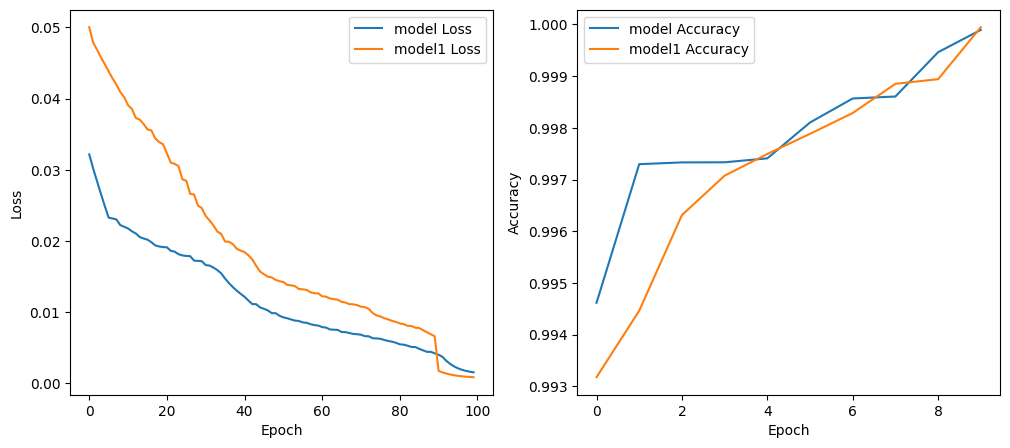

In [15]:
import matplotlib.pyplot as plt

# 绘制训练和测试的损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sorted(train_losses,reverse=True), label='model Loss')
plt.plot(sorted(train_losses1,reverse=True), label='model1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和测试的准确度曲线
plt.subplot(1, 2, 2)
plt.plot(sorted(test_accuracies), label='model Accuracy')
plt.plot(sorted(test_accuracies1), label='model1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
# 加载模型
loaded_model = ImplicitFeedbackModel(num_users, num_news, num_categories, embedding_dim)
loaded_model.load_state_dict(torch.load('model_weights1.pth'))
loaded_model.eval()

ImplicitFeedbackModel(
  (user_embed): Embedding(200000, 32)
  (news_embed): Embedding(31116, 32)
  (category_embed): Embedding(290, 32)
  (fc1): Linear(in_features=96, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [21]:
count = 0
# 遍历 'user_predict' 中的每个用户
for user_id in user_predict['user_id']:

    # 提取当前批次的数据
    data = merged_df[['user_id', 'news_id', 'cateory']].copy()

    users = data['user_id'].unique()
    # new_category = news['news_id']
    all_combinations = pd.DataFrame([(user_id, n, c) for n, c in nc], columns=['user_id', 'news_id', 'cateory'])
    data = pd.merge(all_combinations, data, on=['user_id', 'news_id', 'cateory'], how='left')

    # 数据预处理：将用户ID、新闻ID、类别特征进行标签编码
    user_encoder = LabelEncoder()
    news_encoder = LabelEncoder()
    category_encoder = LabelEncoder()

    data['user_id'] = user_encoder.fit_transform(data['user_id'])
    data['news_id'] = news_encoder.fit_transform(data['news_id'])
    data['cateory'] = category_encoder.fit_transform(data['cateory'])

    new_inputs = torch.LongTensor(data.values)
    with torch.no_grad():
        new_outputs = loaded_model(new_inputs[:, 0], new_inputs[:, 1], new_inputs[:, 2])
        new_predictions = torch.sigmoid(new_outputs)

    # 打印新数据的预测结果
    # print(new_predictions)
    data['predict'] = new_predictions
    # 根据predict列进行降序排序
    tmp_sorted = data.sort_values(by='predict', ascending=False)
    top_50_news_ids = tmp_sorted.head(50)['news_id']

    # 打印结果
    # print(top_50_news_ids)

    # 筛选click_history中user_id的数据
    click_history_filtered = click_history[click_history['user_id'] == user_id]

    # 遍历top_50_news_ids，查看是否在click_history_filtered的news_id中
    for news_id in top_50_news_ids:
        if news_id in click_history_filtered['news_id'].values:
            count += 1
        else:
            continue

print(count)

216
